# Bayesian optimization with parallel evaluation of an external objection function using Emukit

This tutorial will show you how to leverage Emukit to do Bayesian optimization on an external objective function that we can evaluate multiple times in parallel.

## Overview

By the end of the tutorial, you will be able to:

1. Generate batches $\{X_t | t \in 1..\}$ of objective function evaluation locations $\{x_i | x_i \in X_t\}$
2. Evaluate the objective function at these suggested locations in parallel $f(x_i)$
3. Use `asyncio` to implement the concurrency structure supporting this parallel evaluation

This tutorial requires basic familiarity with Bayesian optimization and concurrency. If you've never run Bayesian optimization using Emukit before, please refer to the [introductory tutorial](Emukit-tutorial-intro.ipynb) for more information. The concurrency used here is not particularly complicated, so you should be able to follow just fine without much more than an understanding of the [active object design pattern](https://en.wikipedia.org/wiki/Active_object).

The overview must start with the general imports and plots configuration

The overview section must finish with a Navigation that links to the main sections of the notebook


In [58]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
LEGEND_SIZE = 15
TITLE_SIZE = 25
AXIS_SIZE = 15
FIG_SIZE = (12,8)

### Navigation

1. [Define Objective Function](#1.-Define-objective-function)

2. [Setup BO & Run BO](#2.-Run-BO-using-parallel-evaluation-of-batched-suggestions)

3. [Conclusions](#3.-Conclusions)

## 1. Define objective function

In [59]:
# Specific imports that are used in a section should be loaded at the beginning of that section.
# It is ok if an import is repeated multiple times over the notebook

import time
import asyncio
import GPy
import emukit
import numpy as np
from math import pi

from emukit.test_functions.branin import (
    branin_function as _branin_function,
)

In [60]:
### Define the cost and objective functions

_branin, _ps = _branin_function()

async def a_cost(x: np.ndarray):
    # Cost function, defined arbitrarily
    t = max(x.sum()/10, 0.1)
    await asyncio.sleep(t)

async def a_objective(x: np.ndarray):
    # Objective function
    r = _branin(x)
    await a_cost(x)
    return r

async def demo_async_obj():
    '''This function demonstrates a simple usage of the async objective function'''
    # Configure
    _x = [7.5, 12.5]
    d = len(_x)
    x = np.array(_x).reshape((1, d))
    assert _ps.check_points_in_domain(x).all(), ("You configured a point outside the objective"
        f"function's domain: {x} is outside {_ps.get_bounds()}")
    # Execute
    print(f"Input: x={x}")
    t0 = time.perf_counter()
    r = await a_objective(x)
    t1 = time.perf_counter()
    print(f"Output: result={r}")
    print(f"Time elapsed: {t1-t0} sec")

In [61]:
await demo_async_obj()

Input: x=[[ 7.5 12.5]]
Output: result=[[138.09715472]]
Time elapsed: 2.0004054110013385 sec


## 2. Run BO using parallel evaluation of batched suggestions

In [62]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper, UserFunctionResult
from emukit.core.loop.stopping_conditions import FixedIterationsStoppingCondition
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound

import warnings
warnings.filterwarnings('ignore')  # to quell the numerical errors in hyperparameter fitting

In [63]:
# Plotting stuff (from constrained optimization tutorial)
x1b, x2b = _ps.get_bounds()
plot_granularity = 50
x_1 = np.linspace(x1b[0], x1b[1], plot_granularity)
x_2 = np.linspace(x2b[0], x2b[1], plot_granularity)
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2)
x_all = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)
y_all = _branin(x_all)
y_reshape = np.reshape(y_all, x_1_grid.shape)
x_best = np.array([(-pi,12.275), (pi,2.275), (9.425,2.475)])

def plot_progress(loop_state, batch_size: int):
    plt.figure(figsize=FIG_SIZE)
    plt.contourf(x_1, x_2, y_reshape)
    plt.plot(loop_state.X[:-batch_size, 0], loop_state.X[:-batch_size, 1], linestyle='', marker='.', markersize=16, color='b')
    plt.plot(loop_state.X[-batch_size:, 0], loop_state.X[-batch_size:, 1], linestyle='', marker='.', markersize=16, color='r')
    plt.plot(x_best[:,0], x_best[:,1], linestyle='', marker='x', markersize=18, color='g')
    plt.legend(['Previously evaluated points', 'Last evaluation', 'True best'])
    plt.show()

Optimizing: n=6


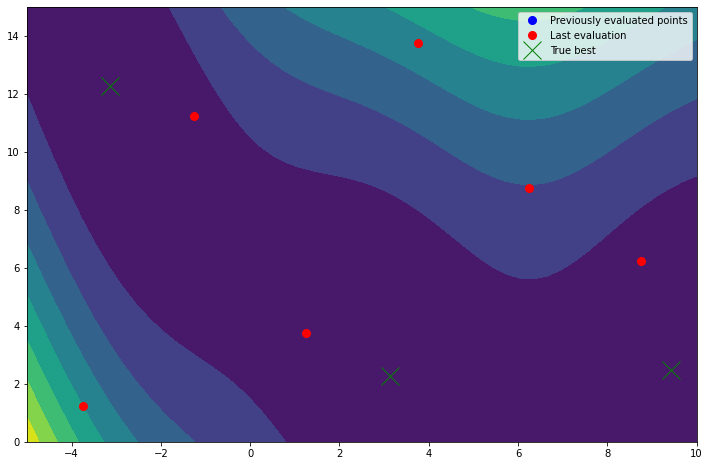

Optimizing: n=12
Optimization restart 1/1, f = 67.9314722375802


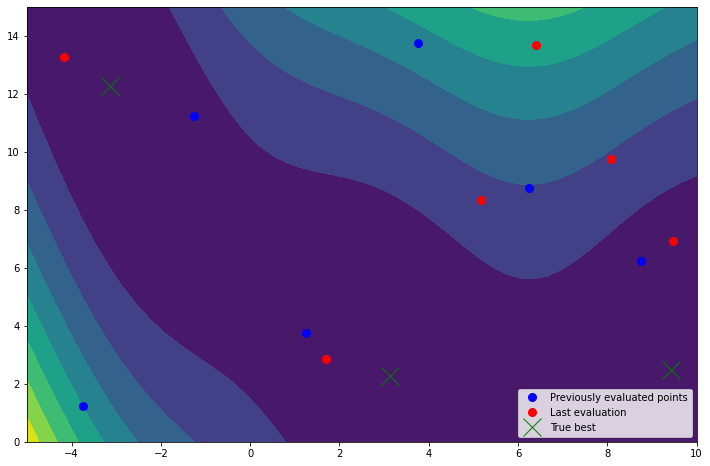

Optimizing: n=18
Optimization restart 1/1, f = 99.8958865774074


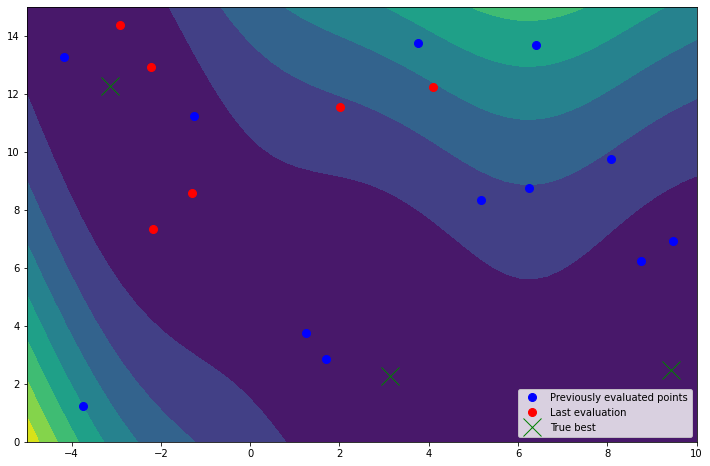

Optimizing: n=24
Optimization restart 1/1, f = 130.40810304963375


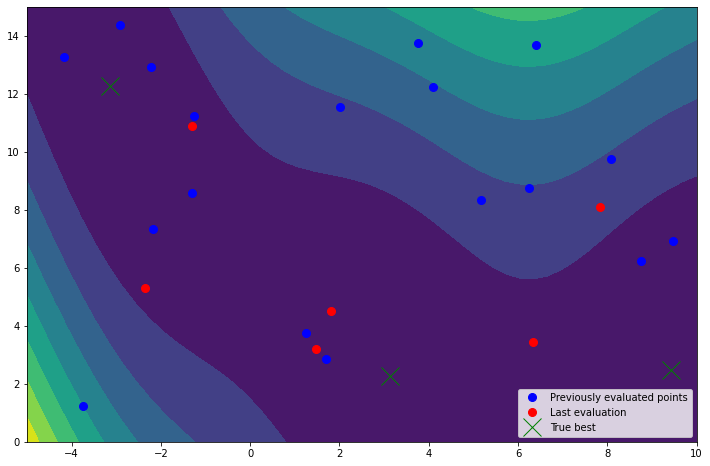

Optimizing: n=30
Optimization restart 1/1, f = 161.27415999643415


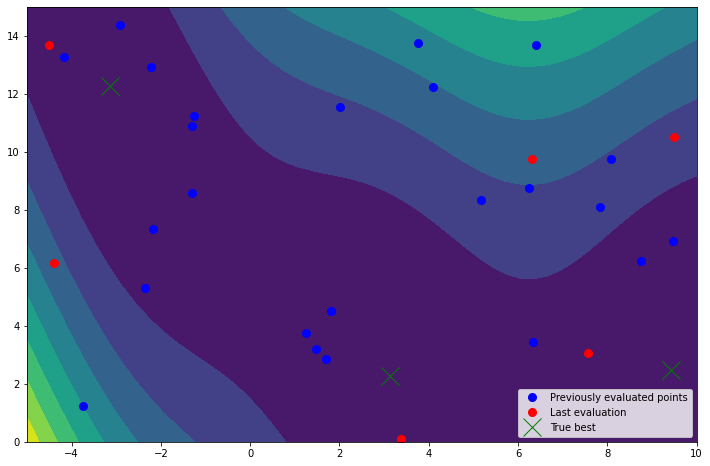

Optimizing: n=36
Optimization restart 1/1, f = 192.40954770570556


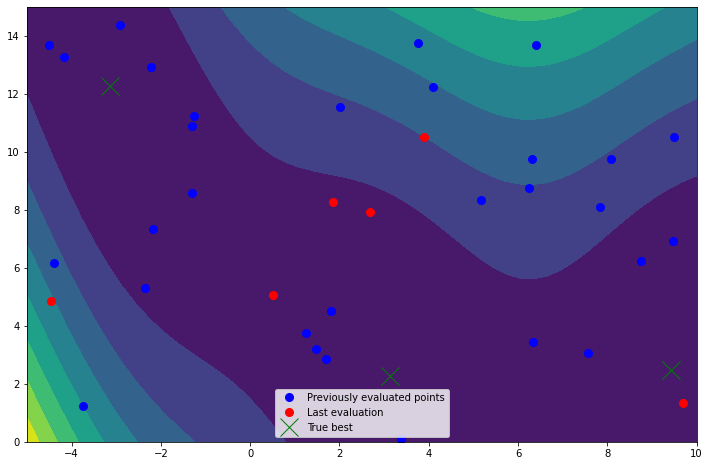

Optimizing: n=42
Optimization restart 1/1, f = 227.31320085305367


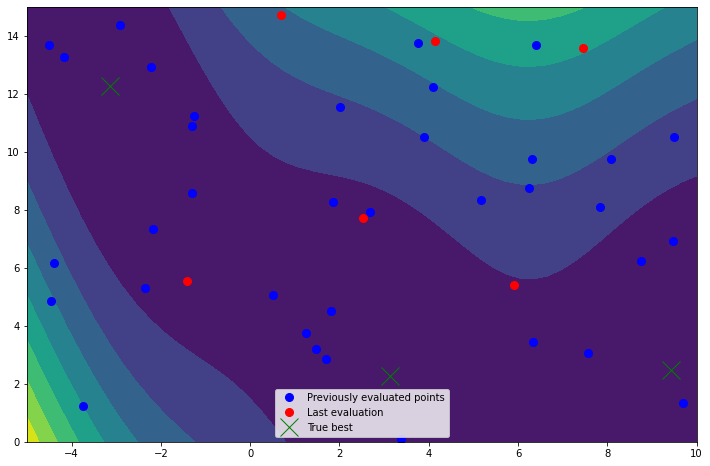

Optimizing: n=48
Optimization restart 1/1, f = 257.7513614708086


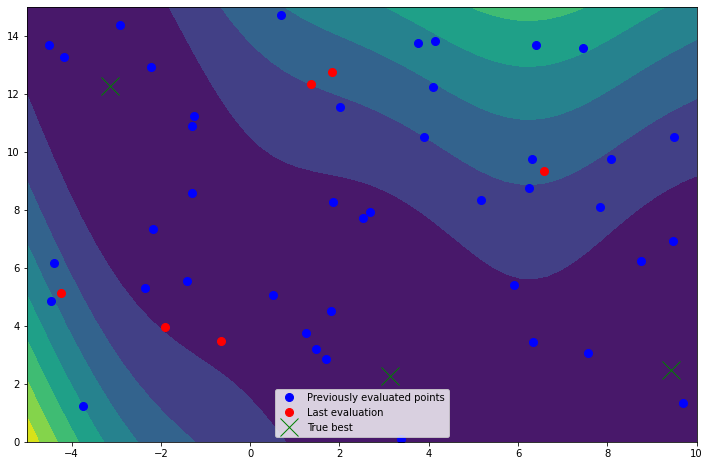

############################################################
Minimum found at location: [9.70367525 1.35489612]
	with score: 2.6332561487902275
True minima at:
[[-3.14159265 12.275     ]
 [ 3.14159265  2.275     ]
 [ 9.425       2.475     ]]
	with score: 0.397887
	source: https://www.sfu.ca/~ssurjano/branin.html
############################################################


In [69]:
async def async_run_bo():
    # Configure
    max_iter = 50
    n_init = 6
    batch_size = 6
    beta = 0.1  # tradeoff parameter for NCLB acq. opt.
    update_interval = 1  # how many results before running hyperparam. opt.
    # Build Bayesian optimization components
    space = _ps
    design = LatinDesign(space)
    X_init = design.get_samples(n_init)
    input_coroutines = [a_objective(x.reshape((1,space.dimensionality))) for x in X_init]
    _Y_init = await asyncio.gather(*input_coroutines, return_exceptions=True)
    Y_init = np.concatenate(_Y_init)
    model_gpy = GPRegression(X_init, Y_init)
    model_gpy.optimize()
    model_emukit = GPyModelWrapper(model_gpy)
    acquisition_function = NegativeLowerConfidenceBound(model=model_emukit, beta=beta)
    acquisition_optimizer = GradientAcquisitionOptimizer(space=space)
    bo_loop = BayesianOptimizationLoop(
        model = model_emukit,
        space = space,
        acquisition = acquisition_function,
        acquisition_optimizer = acquisition_optimizer,
        update_interval = update_interval,
        batch_size = batch_size,
    )
    # Run BO loop
    results = None
    n = bo_loop.model.X.shape[0]
    while n < max_iter:
        print(f"Optimizing: n={n}")
        # TODO use a different acquisition function because currently X_batch is 5 identical sugg.
        # ^ only on occasion, apparently
        X_batch = bo_loop.get_next_points(results)
        coroutines = [a_objective(x.reshape((1, space.dimensionality))) for x in X_batch]
        # TODO update model as soon as any result is available
        # ^ as-is, only updates and makes new suggestions when all results come in
        # TODO make suggestions cost-aware
        _results = await asyncio.gather(*coroutines, return_exceptions=True)
        Y_batch = np.concatenate(_results)
        results = list(map(UserFunctionResult, X_batch, Y_batch))
        n = n + len(results)
        plot_progress(bo_loop.loop_state, batch_size)
    final_result = bo_loop.get_results()
    true_best = 0.397887
    # rel_err = (final_result.minimum_value - true_best)/true_best
    print(
        "############################################################\n"
        f"Minimum found at location: {final_result.minimum_location}\n"
        f"\twith score: {final_result.minimum_value}\n"
        f"True minima at:\n{x_best}\n"
        f"\twith score: {true_best}\n"
        # f"Relative error (%): {rel_err*100:.2f}\n"
        "\tsource: https://www.sfu.ca/~ssurjano/branin.html\n"
        "############################################################"
        )
    
await async_run_bo()

## 3. Conclusions

1. I generated batches of suggestions using the `bo_loop.get_next_points()` function having configured the `bo_loop` with `batch_size` > 1
2. I evaluated these suggestions in parallel using `_Y_init = await asyncio.gather(*input_coroutines, return_exceptions=True)`
3. The `asyncio` structure is bare-bones:
    1. The coroutines are prepared by mapping the async external objective function over the inputs
    2. The coroutines are executed using `asyncio.gather`